# Test the output of a Dataloader with a calibrated task

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)

from nnood.paths import raw_data_base, preprocessed_data_base

def wl_to_lh(window, level):
    low = level - window / 2
    high = level + window / 2
    return low,high

def display_image(img, phys_size=None, window=None, level=None, existing_ax=None):

    if window is None:
        window = np.max(img) - np.min(img)

    if level is None:
        level = window / 2 + np.min(img)

    low,high = wl_to_lh(window,level)

    if existing_ax is None:
        # Display the orthogonal slices
        fig, axes = plt.subplots(figsize=(14, 8))
    else:
        axes = existing_ax

    axes.imshow(img, clim=(low, high), extent= None if phys_size is None else (0, phys_size[0], phys_size[1], 0), cmap='gray')

    if existing_ax is None:
        plt.show()
        
def print_stats(arr):
        print(np.mean(arr),', ',np.std(arr))
        print(np.min(arr), '-', np.max(arr))
        print(arr.shape)

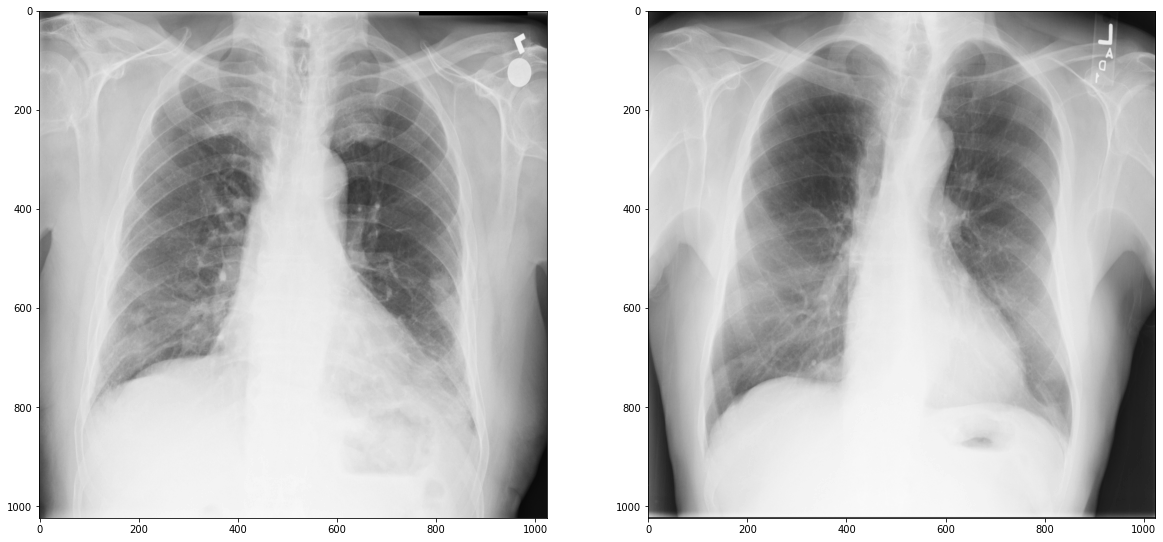

In [2]:
from nnood.paths import default_data_identifier, default_plans_identifier
from nnood.utils.file_operations import load_pickle
from nnood.training.dataloading.dataset_loading import load_dataset_filenames
from nnood.preprocessing.normalisation import denormalise

dataset_name = 'chestXray14_PA_male'

plans_file = Path(preprocessed_data_base, dataset_name, default_plans_identifier)
test_image_dir = Path(preprocessed_data_base, dataset_name, default_data_identifier + '_stage0')

plans = load_pickle(plans_file)
curr_stage_plan = plans['plans_per_stage'][0]

patch_size = curr_stage_plan['patch_size']
batch_size = curr_stage_plan['batch_size']


dataset = load_dataset_filenames(test_image_dir, plans['dataset_properties']['sample_identifiers'])

k1, k2 = list(dataset.keys())[:2]

test_image1 = np.load(dataset[k1]['data_file'])['data']
test_prop1 = load_pickle(dataset[k1]['properties_file'])
test_image2 = np.load(dataset[k2]['data_file'])['data']
test_prop2 = load_pickle(dataset[k2]['properties_file'])

norm_args = (plans['normalization_schemes'],
             plans['dataset_properties']['intensity_properties'],
             test_prop1['channel_intensity_properties'])

fig, axes = plt.subplots(ncols=2, figsize=(20, 10))

display_image(np.moveaxis(denormalise(test_image1, *norm_args), 0, -1), existing_ax=axes[0])
display_image(np.moveaxis(denormalise(test_image2, *norm_args), 0, -1), existing_ax=axes[1])

In [3]:
from nnood.self_supervised_task.fpi import FPI
from nnood.self_supervised_task.cutpaste import CutPaste
from nnood.self_supervised_task.pii import PII
from nnood.self_supervised_task.nsa import NSA, NSAMixed
from time import time

task = PII()

start = time()
task.calibrate(dataset, plans)
print('took ', time() - start)

took  0.0001266002655029297


In [4]:
from nnood.training.dataloading.dataset_loading import DataLoader

test_loader = DataLoader(dataset, patch_size, patch_size, task, batch_size, False,
                         data_has_foreground=plans['plans_per_stage'][0])

In [ ]:
data_batch = test_loader.generate_train_batch()

In [23]:
from matplotlib.patches import Rectangle

def bbox(img):
    rows = np.any(img, axis=0)
    cols = np.any(img, axis=1)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax, cmin, cmax

def display_sample(curr_batch, index):
    data_to_show = curr_batch['data'][index]
    label_to_show = curr_batch['seg'][index][0]
    coords = curr_batch['coords'][index]
    sample_props = curr_batch['properties'][index]
    
    fig, axes = plt.subplots(ncols=3, figsize=(30, 10))
    denorm_sample = np.moveaxis(denormalise(data_to_show, norm_args[0], norm_args[1], sample_props['channel_intensity_properties']),
                                0, -1)
    
    axes[0].imshow(denorm_sample, cmap='gray')
    
    
    axes[1].imshow(denorm_sample, cmap='gray')
    if np.any(label_to_show > 0):
        anom_bbox = bbox(label_to_show)
        axes[1].add_patch(Rectangle((anom_bbox[0], anom_bbox[2]), anom_bbox[1] - anom_bbox[0], anom_bbox[3] - anom_bbox[2], fill=False, edgecolor='red'))
    
    axes[2].imshow(label_to_show)
    anom_vals = label_to_show[label_to_show != 0]

    if len(anom_vals) > 0:
        print('Label vals:', np.min(anom_vals), '-', np.max(anom_vals))
    else: 
        print('No anomaly present')

    print(coords.shape)
    print('Y pos', coords[0][patch_size[0] // 2][patch_size[1] // 2])
    print('X pos', coords[1][patch_size[0] // 2][patch_size[1] // 2])
    
    plt.show()
    
    

Label vals: 0.429387 - 0.429387
(2, 512, 512)
Y pos 0.5014663
X pos 0.0009775171


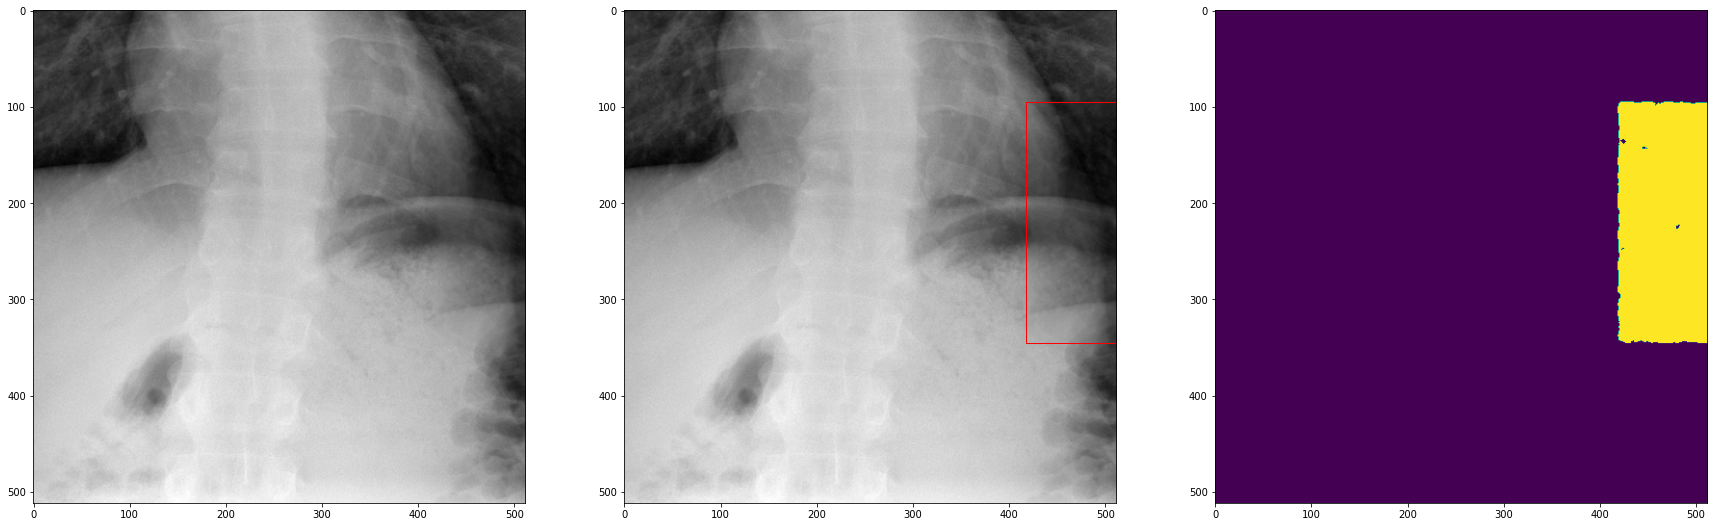

In [26]:
display_sample(data_batch, 1)

# Compare the anomaly coverage of Dataloaders using different self-supervised tasks

This is useful as it is equal to the average precision of a random classifier

In [27]:
from tqdm import tqdm

average_coverage = []
for t in [FPI(), CutPaste(), PII(), NSA(), NSAMixed()]:
    t.calibrate(dataset, plans)

    l = DataLoader(dataset, patch_size, patch_size, t, batch_size, False,
                   data_has_foreground=plans['plans_per_stage'][0])
    
    coverages = []
    for _ in tqdm(range(100)):
        curr_label = l.generate_train_batch()['seg']
        curr_label[curr_label != 0] = 1
        coverages.append(curr_label.mean())
    
    avg_cov = np.mean(coverages)
    p = (t.__class__.__name__, avg_cov)
    print(*p)
    average_coverage.append(p)

100%|██████████████████████████████████████████████████████████████| 100/100 [05:32<00:00,  3.32s/it]

FPI 0.07605049
Calibrating CutPaste...



100%|██████████████████████████████████████████████████████████████| 100/100 [04:28<00:00,  2.68s/it]


CutPaste 0.11066388


100%|██████████████████████████████████████████████████████████████| 100/100 [05:02<00:00,  3.02s/it]

PII 0.074093916



100%|██████████████████████████████████████████████████████████████| 100/100 [09:06<00:00,  5.47s/it]

NSA 0.14654979



100%|██████████████████████████████████████████████████████████████| 100/100 [09:19<00:00,  5.59s/it]

NSAMixed 0.14694227


In [28]:
from PIL import Image

res = []

# Measuring how much of the test images are anomalous
# (useful for calculating baseline average precision)

for dset_name in ['chestXray14_PA_male', 'chestXray14_PA_female']:
    labels_f = Path(raw_data_base, dset_name, 'labelsTs')
    assert labels_f.is_dir()
    
    positive = 0
    negative = 0
    
    for f in tqdm(labels_f.iterdir()):
        with Image.open(f) as im:
            im = im.convert('L')
            im_arr = np.array(im)
            
            p = np.count_nonzero(im_arr)
            positive += p
            
            negative += im_arr.size - p
    
    base_pr = positive / (positive + negative)
    print(dset_name, base_pr)
    
    res.append((dset_name, positive, negative, base_pr))        

245it [00:07, 31.04it/s]


chestXray14_PA_male 0.07403562896105707


217it [00:08, 27.09it/s]

chestXray14_PA_female 0.063470216390724
